## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data_df=pd.read_csv("heart.csv")


In [2]:
data_df.isnull().sum()


age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

In [3]:
data_df['target'].unique()

array([0, 2, 1, 3, 4])

In [4]:
#2. distribution of target variable.
data_df['target'] = np.where(data_df['target']!= 0, 1, 0)
data_df['target'] = data_df['target'].astype('category')
data_df['target'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       920 non-null    int64   
 1   sex       920 non-null    object  
 2   dataset   920 non-null    object  
 3   cp        920 non-null    object  
 4   trestbps  861 non-null    float64 
 5   chol      890 non-null    float64 
 6   fbs       830 non-null    object  
 7   restecg   918 non-null    object  
 8   thalch    865 non-null    float64 
 9   exang     865 non-null    object  
 10  oldpeak   858 non-null    float64 
 11  slope     611 non-null    object  
 12  ca        309 non-null    float64 
 13  thal      434 non-null    object  
 14  target    920 non-null    category
dtypes: category(1), float64(5), int64(1), object(8)
memory usage: 101.8+ KB


Let us proceed by splitting our training and test data and our input and target variables. Since we are using KNN, it is mandatory to scale our datasets too.

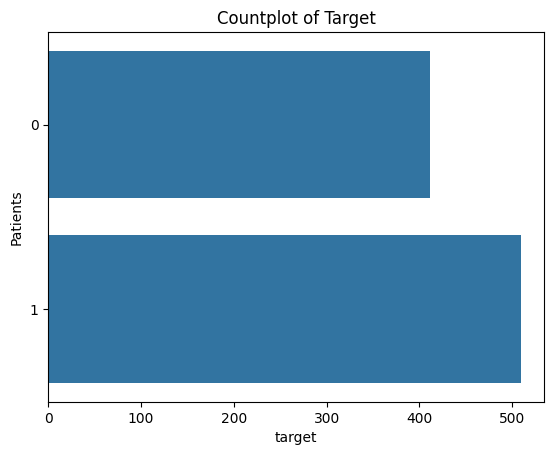

In [6]:
sns.countplot(data_df['target'])

# Add labels
plt.title('Countplot of Target')
plt.xlabel('target')
plt.ylabel('Patients')
plt.show()

In [7]:
# Create a list of categorical columns and numerical columns
cat_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal','dataset']

num_cols = ['age','trestbps','chol','thalch','oldpeak']


In [8]:
df_continuous = data_df[num_cols]
df_continuous.fillna(0, inplace=True)

/home/u213916/tmp/ipykernel_2000516/1546792749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_continuous.fillna(0, inplace=True)


In [9]:
# creating a Knn model
y = data_df["target"].values
x = df_continuous

#Scaling - mandatory for knn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
ss = StandardScaler()
x = ss.fit_transform(x)

#SPlitting into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3) # 70% training and 30% test
y

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


[0, 1, 1, 0, 0, ..., 1, 0, 1, 0, 1]
Length: 920
Categories (2, int64): [0, 1]

The intuition behind choosing the best value of k is beyond the scope of this article, but we should know that we can determine the optimum value of k when we get the highest test score for that value. For that, we can evaluate the training and testing scores for up to 20 nearest neighbors:

In [10]:
from sklearn.neighbors import KNeighborsClassifier
train_score = []
test_score = []
k_vals = []

for k in range(1, 21):
    k_vals.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)

    tr_score = knn.score(X_train, y_train)
    train_score.append(tr_score)

    te_score = knn.score(X_test, y_test)
    test_score.append(te_score)

To evaluate the max test score and the k values associated with it, run the following command:

In [11]:
## score that comes from the testing set only
max_test_score = max(test_score)
test_scores_ind = [i for i, v in enumerate(test_score) if v == max_test_score]
print('Max test score {} and k = {}'.format(max_test_score * 100, list(map(lambda x: x + 1, test_scores_ind))))

Max test score 77.17391304347827 and k = [20]


Thus, we have obtained the optimum value of k to be 3, 11, or 20 with a score of 83.5. We will finalize one of these values and fit the model accordingly:

In [12]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(16)

knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7536231884057971

Now, how do we evaluate whether this model is a ‘good’ model or not? For that, we use something called a Confusion Matrix:

In [13]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve
y_pred = knn.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,92,40,132
1,28,116,144
All,120,156,276


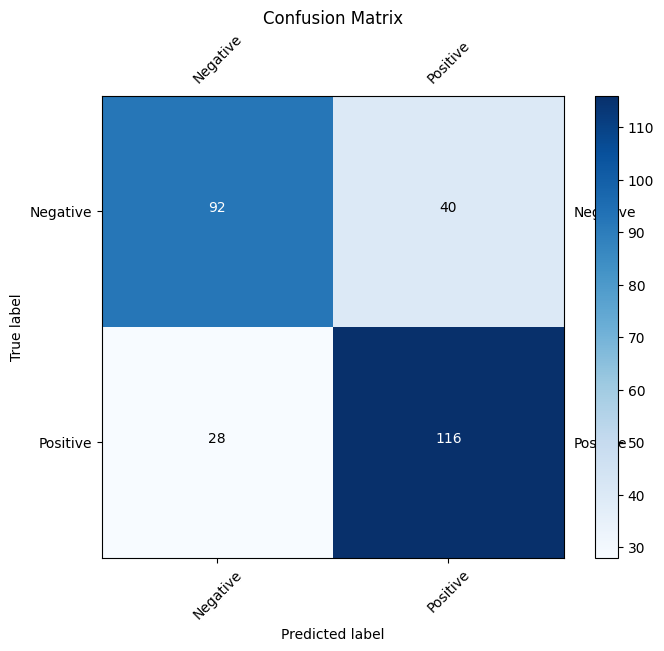

In [14]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45,visible = True)
plt.yticks(tick_marks, classes,visible = True)

plt.xlabel('Predicted label')
plt.ylabel('True label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.show()

In [15]:
acc=np.sum(np.diag(cm))/np.sum(cm)
prec=cm[0,0]/(cm[0,0]+cm[1,0])
recal=cm[0,0]/(cm[0,0]+cm[0,1])
fscore=2*(prec*recal)/(prec+recal)


In [16]:
print("Accuracy:", acc)
print("Precision: ",prec)
print("Recall: ",recal)
print("f1-score: ",fscore)

Accuracy: 0.7536231884057971
Precision:  0.7666666666666667
Recall:  0.696969696969697
f1-score:  0.7301587301587302


All these measures in single function:

In [17]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.70      0.73       132
           1       0.74      0.81      0.77       144

    accuracy                           0.75       276
   macro avg       0.76      0.75      0.75       276
weighted avg       0.75      0.75      0.75       276



In [18]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [19]:
# calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.3f' % auc)

AUC: 0.825


In [20]:
from sklearn.metrics import RocCurveDisplay

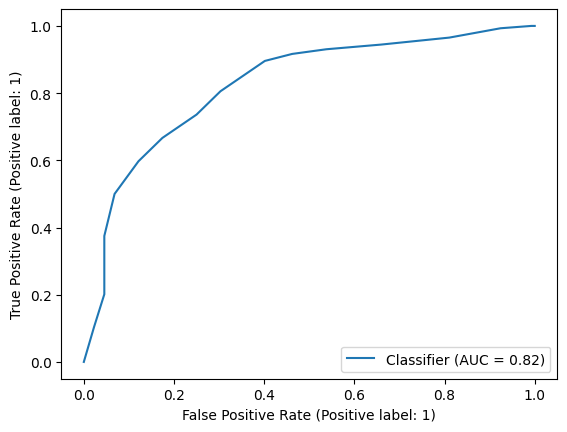

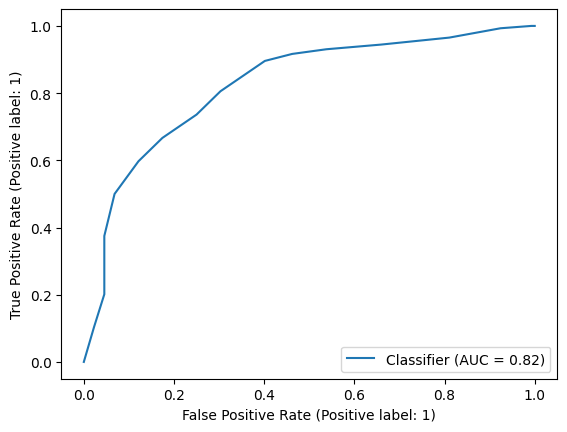

In [21]:
# Create a RocCurveDisplay object
roc_curve_display = RocCurveDisplay.from_predictions(y_test, y_pred_proba)

# Plot the ROC curve
roc_curve_display.plot()

## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [23]:
cm = confusion_matrix(y_test,y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7463768115942029
Precision: 0.7283950617283951
Recall: 0.8194444444444444


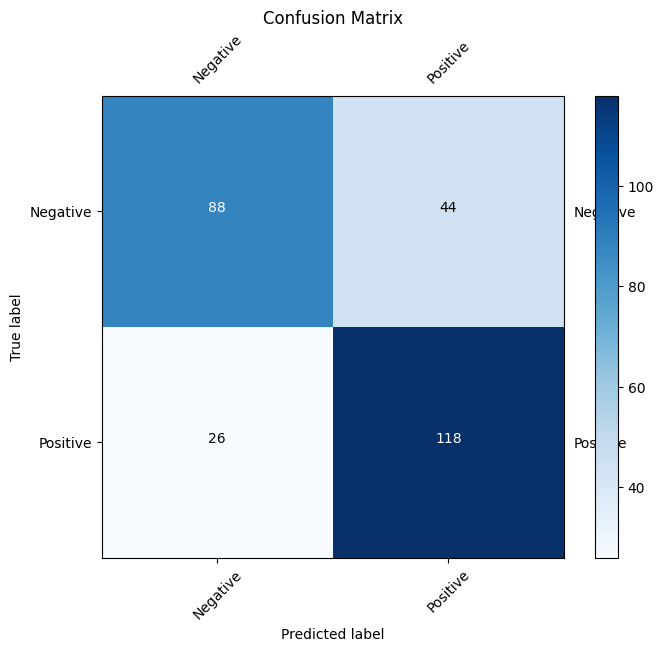

In [24]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45,visible = True)
plt.yticks(tick_marks, classes,visible = True)

plt.xlabel('Predicted label')
plt.ylabel('True label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.show()

In [25]:
y_pred_proba = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.3f' % auc)
from sklearn.metrics import RocCurveDisplay

AUC: 0.812


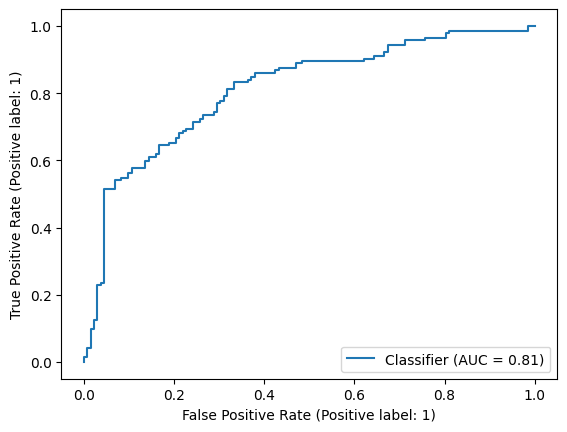

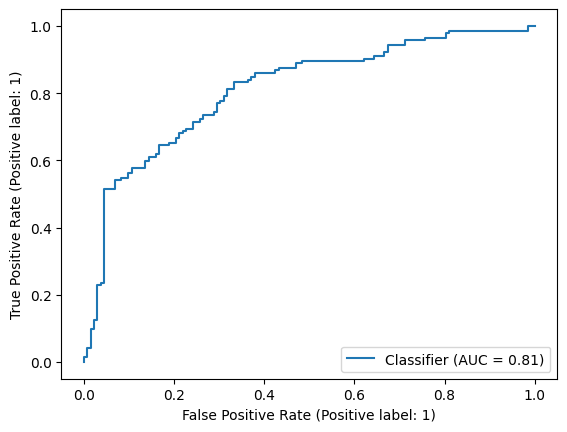

In [26]:
# Create a RocCurveDisplay object
roc_curve_display = RocCurveDisplay.from_predictions(y_test, y_pred_proba)

# Plot the ROC curve
roc_curve_display.plot()

## Decision Tree Models

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
# Create a Decision Tree Classifier with the "entropy" criterion
clf = DecisionTreeClassifier(criterion="entropy")
# Train the classifier on the training set
clf.fit(X_train, y_train)
# Make predictions on the testing set
y_pred = clf.predict(X_test)

In [ ]:
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(X_train, y_train))


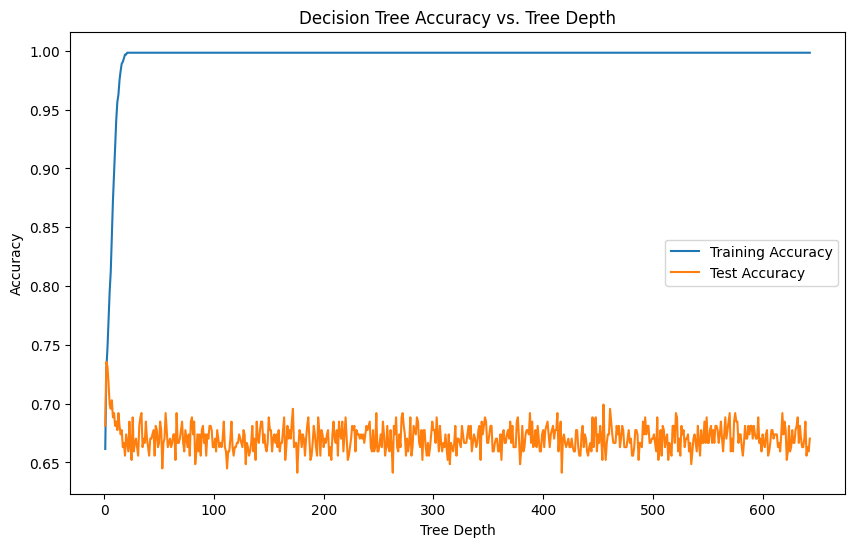

In [30]:
train_accuracy = []
test_accuracy = []
depths = np.arange(1,len(X_train))
for depth in depths:
    # Create a Decision Tree Classifier with the specified depth
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth)


    # Train the classifier on the training set
    clf.fit(X_train, y_train)

    # Make predictions on the training and testing sets
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Calculate and store accuracy values
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

# Plot the accuracy values
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracy, label="Training Accuracy")
plt.plot(depths, test_accuracy, label="Test Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy vs. Tree Depth")
plt.legend()
plt.show()

AUC: 0.668


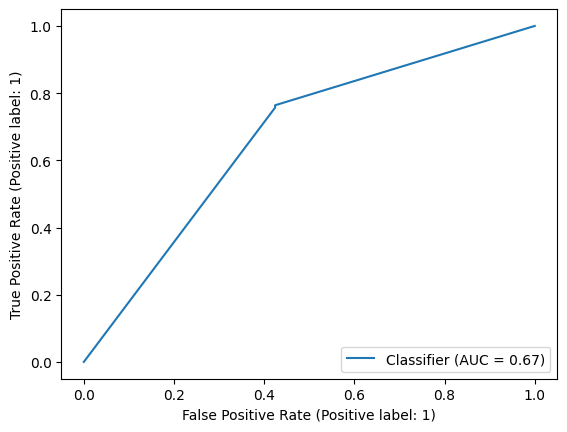

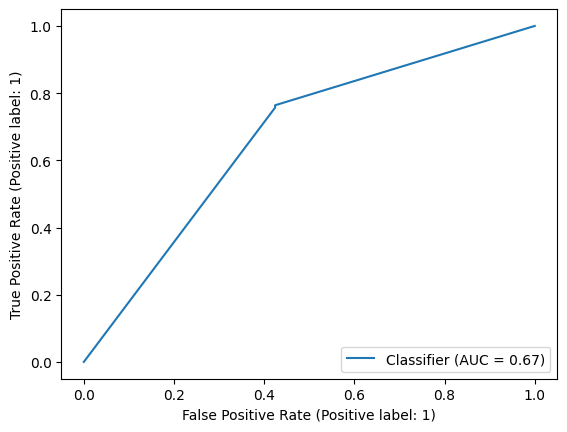

In [31]:
y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.3f' % auc)
from sklearn.metrics import RocCurveDisplay
# Create a RocCurveDisplay object
roc_curve_display = RocCurveDisplay.from_predictions(y_test, y_pred_proba)

# Plot the ROC curve
roc_curve_display.plot()

## SVM model

In [36]:
from sklearn import svm
svm_clf = svm.SVC(kernel='linear',probability = True) # Linear Kernel

#Train the model using the training sets
svm_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svm_clf.predict(X_test)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


AUC: 0.814


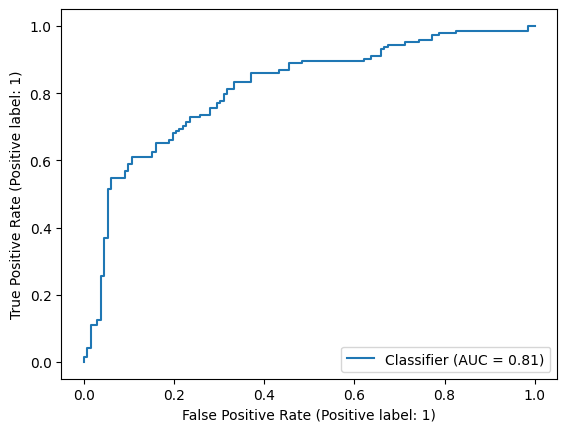

In [37]:


y_pred_proba = svm_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.3f' % auc)
from sklearn.metrics import RocCurveDisplay
# Create a RocCurveDisplay object
roc_curve_display = RocCurveDisplay.from_predictions(y_test, y_pred_proba)

